In [7]:
import pickle
import networkx as nx
import torch
import numpy as np
from communityaware.perturb import _perturb_graph_vmap
import grakel
import matplotlib.pyplot as plt
import pickle

In [2]:
def make_er_motif(n, motif):
    while True:
        target_degree = (2 + len(motif)-1) / 2
        graph = nx.erdos_renyi_graph(n, 0.5)
        connected = nx.is_connected(graph)
        if connected:
            break
    
    graph = nx.relabel_nodes(graph, {i: i+motif.number_of_nodes() for i in range(n)})
    graph.add_edges_from(motif.edges())
    graph.add_edge(motif.number_of_nodes()-1, motif.number_of_nodes())
    graph = add_attributes(graph)
    return graph

def add_attributes(graph, use_degree=True):
    if use_degree:
        nx.set_node_attributes(graph, {i: graph.degree(i) for i in graph.nodes()}, 'node_label')
    else:
        nx.set_node_attributes(graph, {i: 1 for i in graph.nodes()}, 'node_label')
    nx.set_edge_attributes(graph, {i: 1 for i in graph.edges()}, 'edge_label')
    return graph

In [4]:
motif_n = 10
random_n = 10

motif1 = nx.cycle_graph(motif_n)
motif2 = nx.complete_graph(motif_n)

graph1 = make_er_motif(random_n, motif1)
graph2 = make_er_motif(random_n, motif2)

In [39]:
number_of_nodes = motif_n + random_n
p1 = 0.05
p2 = 0.45

noise_matrix = np.zeros((number_of_nodes, number_of_nodes))
for i in range(motif_n):
    for j in range(i+1, motif_n):
        if i == 0 and j == motif_n-1:
            continue
        elif i == j - 1:
            continue
        else:
            noise_matrix[i, j] = p1

noise_matrix = noise_matrix + noise_matrix.T
noise_matrix[motif_n:, motif_n:] = p2


# no self-loops and put into torch format
np.fill_diagonal(noise_matrix, 0)
noise_matrix = torch.tensor(noise_matrix)

In [40]:
noise_matrix_isotropic = np.ones((number_of_nodes, number_of_nodes)) * p1
np.fill_diagonal(noise_matrix_isotropic, 0)
noise_matrix_isotropic = torch.tensor(noise_matrix_isotropic)

In [41]:
def perturb_graph(graph, noise_matrix):
    A = torch.tensor(np.array(nx.adjacency_matrix(graph, nodelist=range(graph.number_of_nodes())).todense()))
    perturbed_graph = _perturb_graph_vmap(A.unsqueeze(0), noise_matrix.unsqueeze(0)).numpy()
    perturbed_graph = nx.from_numpy_matrix(perturbed_graph.squeeze())
    return perturbed_graph

In [43]:
data = []
for _ in range(100):
    graph1 = make_er_motif(random_n, motif1)
    [data.append((graph1.degree(i), 'negative', 'clean', 'negative_clean'))  for i in graph1.nodes()]

for _ in range(100):
    graph2 = make_er_motif(random_n, motif2)
    [data.append((graph2.degree(i), 'positive', 'clean', 'positive_clean'))  for i in graph2.nodes()]

for _ in range(100):
    graph1 = perturb_graph(make_er_motif(random_n, motif1), noise_matrix)
    [data.append((graph1.degree(i), 'negative', 'anisotropic', 'negative_anis'))  for i in graph1.nodes()]

for _ in range(100):
    graph2 = perturb_graph(make_er_motif(random_n, motif2), noise_matrix)
    [data.append((graph2.degree(i), 'positive', 'anisotropic', 'positive_anis'))  for i in graph2.nodes()]

for _ in range(100):
    graph1 = perturb_graph(make_er_motif(random_n, motif1), noise_matrix_isotropic)
    [data.append((graph1.degree(i), 'negative', 'isotropic', 'negative_iso'))  for i in graph1.nodes()]

for _ in range(100):
    graph2 = perturb_graph(make_er_motif(random_n, motif2), noise_matrix_isotropic)
    [data.append((graph2.degree(i), 'positive', 'isotropic', 'positive_iso'))  for i in graph2.nodes()]

/tmp/ipykernel_17150/3195063783.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = torch.tensor(np.array(nx.adjacency_matrix(graph, nodelist=range(graph.number_of_nodes())).todense()))


<AxesSubplot:xlabel='degree', ylabel='Percent'>

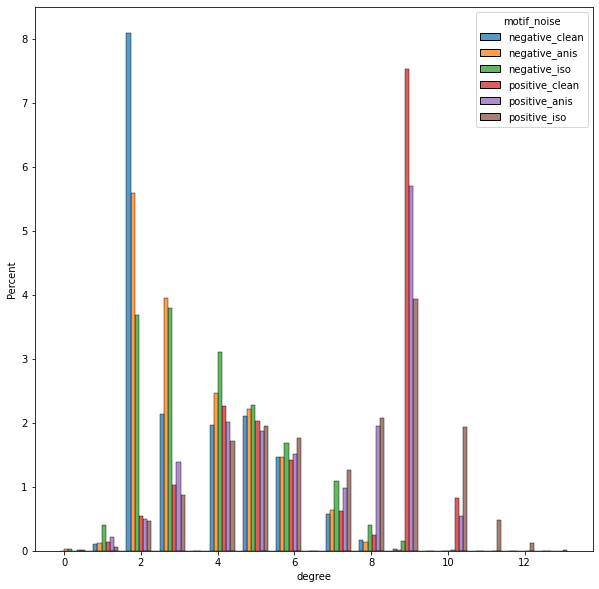

In [55]:
import seaborn as sns
import pandas as pd

fig, ax = plt.subplots(figsize=(10, 10))
df = pd.DataFrame(data, columns=['degree', 'motif', 'noise', 'motif_noise'])
hue_order=['negative_clean', 'negative_anis',  'negative_iso', 'positive_clean', 'positive_anis', 'positive_iso']
sns.histplot(df, x='degree', hue='motif_noise', multiple="dodge", ax=ax, hue_order=hue_order, common_norm=True, stat='percent', shrink=1.5)

/tmp/ipykernel_26450/27465004.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  plt.imshow(nx.adjacency_matrix(graph1).todense())


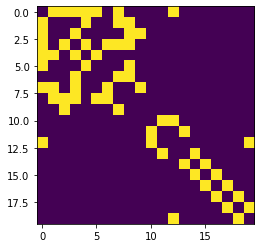

In [64]:
plt.imshow(nx.adjacency_matrix(graph1).todense())

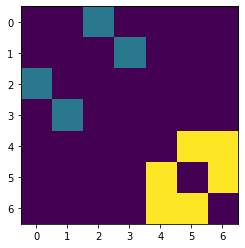

In [80]:
motif_n = 4
random_n = 3

number_of_nodes = motif_n + random_n
p1 = 0.2
p2 = 0.5

if p2 is None: # isotropic noise
    noise_matrix = np.ones((number_of_nodes, number_of_nodes)) * p1
else:
    noise_matrix = np.zeros((number_of_nodes, number_of_nodes))
    for i in range(motif_n):
        for j in range(i+1, motif_n):
            if i == 0 and j == motif_n-1:
                continue
            elif i == j - 1:
                continue
            else:
                noise_matrix[i, j] = p1

    noise_matrix = noise_matrix + noise_matrix.T
    noise_matrix[motif_n:, motif_n:] = p2


# no self-loops and put into torch format
np.fill_diagonal(noise_matrix, 0)
noise_matrix = torch.tensor(noise_matrix).numpy()

plt.imshow(noise_matrix)

In [68]:
i == 0

False

In [15]:
MyMalNetTiny('data/malnet')

FileNotFoundError: [Errno 2] No such file or directory: 'data/malnet/processed/data.pt'

In [16]:
dataset = torch_geometric.datasets.MalNetTiny('data/malnet')

Extracting data/malnet/raw/malnet-graphs-tiny.tar.gz


KeyboardInterrupt: 

Extracting data/malnet/raw/malnet-graphs-tiny.tar.gz
Processing...
Done!


MalNetTiny(5000)

In [41]:
hasattr(dataset, 'process')

True